In [5]:
import jax

# STATS 607
## Week 3: Automatic differentiation

## Computing derviatives

- In statistical inference, we often need to navigate to the (local) minimum/maximum of a function:
    - Least squares: $\min_\beta \| X\beta - y \|^2$
    - MLE: $\max \log p(x\mid \theta)$
    - Method of moments: $\min_\theta \| \hat{m} - m(\theta) \|$
    - Bayesian: sample around the mode of $p(\theta \mid x)$

- To do this efficiently, we need to know about the _geometry_ of a function. 
- "Which way is up?"
    

## Methods to compute derivatives
- By hand (calculus)
- Symbolically
- Numerically
- **Automatically**

## Example function

$$f(x, y) = x y + \sin(x)$$

### By hand

From calculus we know that

\begin{align}
\partial f / \partial x &= y + \cos (x) \\
\partial f / \partial y &= x
\end{align}

But this won't work for even moderately complicated functions. You are bound to make an error!

### Symbolically

Use a symbolic algebra progam to compute the derivatives:

In [3]:
import sympy

x, y = sympy.var('x y')
f = x * y + sympy.sin(x); f

x*y + sin(x)

In [5]:
sympy.diff(f, y)

x

- Symbolic differentiation quickly runs into "expression creep". 
- Logistic map: 
    - $\ell_1 = x$ 
    - $\ell_{n+1} = 4 \ell_n (1 - \ell_n)$

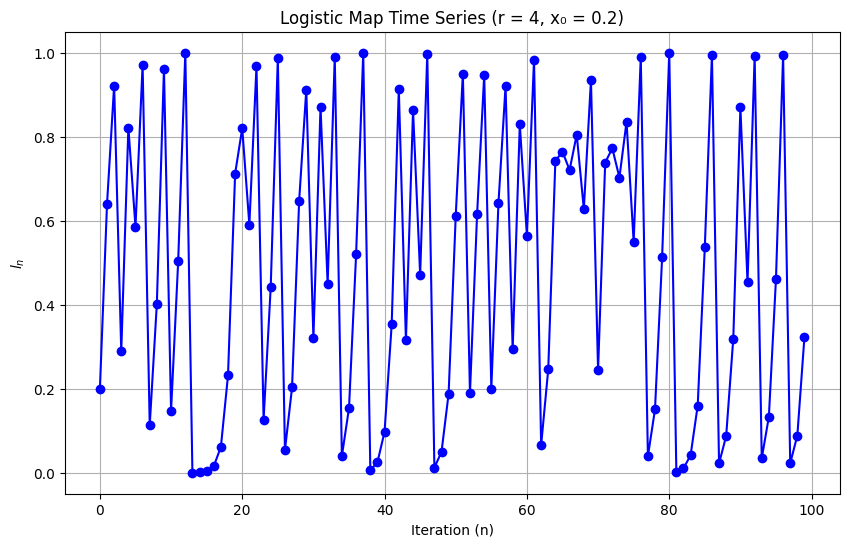

In [8]:
import numpy as np
import matplotlib.pyplot as plt

def logistic_map(r, x):
    return r * x * (1 - x)

# Parameters for the time series plot
r = 4
x0 = 0.2  # Initial value (0 < x0 < 1)
n_iterations = 100

# Initialize array to store the values
x_values = np.zeros(n_iterations)
x_values[0] = x0

# Iterate the logistic map
for i in range(1, n_iterations):
    x_values[i] = logistic_map(r, x_values[i - 1])

# Plot the time series
plt.figure(figsize=(10, 6))
plt.plot(range(n_iterations), x_values, marker='o', linestyle='-', color='blue')
plt.title(f'Logistic Map Time Series (r = {r}, x₀ = {x0})')
plt.xlabel('Iteration (n)')
plt.ylabel('$l_n$')
plt.grid(True)
plt.show()

In [9]:
def ell(n):
    if n == 1:
        return x
    eln = ell(n - 1)
    return 4 * eln * (1 - eln)

sympy.diff(ell(8), x)

16384*x*(1 - x)*(8*x - 4)*(-16*x*(1 - x)*(-4*x*(1 - x) + 1) + 1)*(-64*x*(1 - x)*(-4*x*(1 - x) + 1)*(-16*x*(1 - x)*(-4*x*(1 - x) + 1) + 1) + 1)*(-256*x*(1 - x)*(-4*x*(1 - x) + 1)*(-16*x*(1 - x)*(-4*x*(1 - x) + 1) + 1)*(-64*x*(1 - x)*(-4*x*(1 - x) + 1)*(-16*x*(1 - x)*(-4*x*(1 - x) + 1) + 1) + 1) + 1)*(-1024*x*(1 - x)*(-4*x*(1 - x) + 1)*(-16*x*(1 - x)*(-4*x*(1 - x) + 1) + 1)*(-64*x*(1 - x)*(-4*x*(1 - x) + 1)*(-16*x*(1 - x)*(-4*x*(1 - x) + 1) + 1) + 1)*(-256*x*(1 - x)*(-4*x*(1 - x) + 1)*(-16*x*(1 - x)*(-4*x*(1 - x) + 1) + 1)*(-64*x*(1 - x)*(-4*x*(1 - x) + 1)*(-16*x*(1 - x)*(-4*x*(1 - x) + 1) + 1) + 1) + 1) + 1)*(-4096*x*(1 - x)*(-4*x*(1 - x) + 1)*(-16*x*(1 - x)*(-4*x*(1 - x) + 1) + 1)*(-64*x*(1 - x)*(-4*x*(1 - x) + 1)*(-16*x*(1 - x)*(-4*x*(1 - x) + 1) + 1) + 1)*(-256*x*(1 - x)*(-4*x*(1 - x) + 1)*(-16*x*(1 - x)*(-4*x*(1 - x) + 1) + 1)*(-64*x*(1 - x)*(-4*x*(1 - x) + 1)*(-16*x*(1 - x)*(-4*x*(1 - x) + 1) + 1) + 1) + 1)*(-1024*x*(1 - x)*(-4*x*(1 - x) + 1)*(-16*x*(1 - x)*(-4*x*(1 - x) + 1) + 1)*

### Numerical differentiation

- Uses finite differences to approximate the derivative:

  $$f'(x) \approx \frac{f(x + h) - f(x)}{h}$$
    
  for very small $h$.

- Disadvantages:
    - Costs $\mathcal{O}(d)$ when $x \in \mathbb{R}^d$.
    - Potentially inaccurate: approximation error ($h$ too large); underflow ($h$ too small).

In [10]:
import numpy as np
import matplotlib.pyplot as plt

def f(x):
    return 64 * x * (1 - x) * (1 - 2 * x)**2 * (1 - 8 * x + 8 * x**2)**2

df_exact = sympy.lambdify(x, f(x).diff(x))

Text(0, 0.5, 'Error')

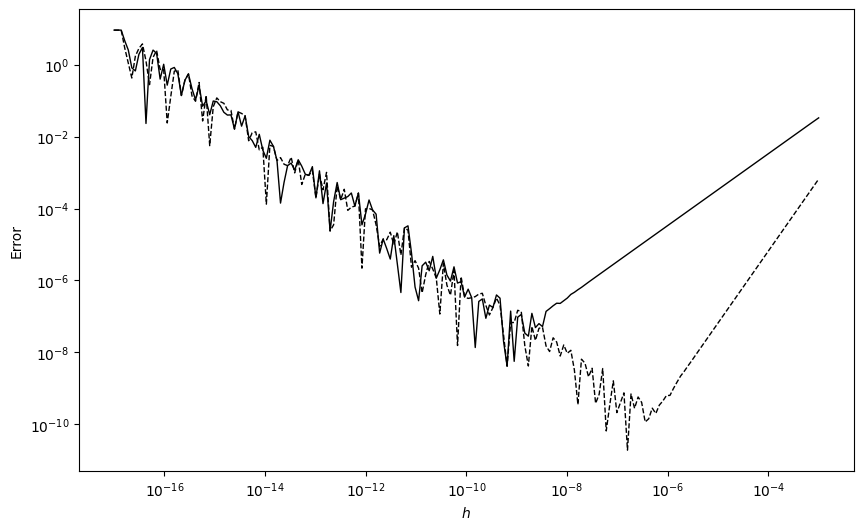

## Forward mode AD
- Forward mode autodiff essentially automates the process you learned in calculus. 
- Let's differentiate $z = x y + \sin(x)$. 
- The computer sees this as:

      x = <input>
      y = <input>
      a = x * y
      b = sin(x)
      z = a * b

- Now let's consider differentiating with respect to some input variable $t$. 
- We differentiate each step of the program with respect to $t$:

\begin{align}
\frac{\partial x}{\partial t} &= {?} \\
\frac{\partial y}{\partial t} &= {?} \\
\frac{\partial a}{\partial t} &= y \cdot \frac{\partial x}{\partial t} + x \cdot \frac{\partial y}{\partial t} \\
\frac{\partial b}{\partial t} &= \cos(x) \cdot \frac{\partial x}{\partial t} \\
\frac{\partial z}{\partial t} &= \frac{\partial a}{\partial t} + \frac{\partial b}{\partial t}
\end{align}
    

- Substituting $t=x$, we get $\partial x/\partial x=1$, $\partial y/\partial x=0$, and all the other partials are determined.
- Similarly for $t=y$.
- We can automatically translate the above function into one that computes derivatives:

        dx = ?
        dy = ?
        da = y * dx + x * dy
        db = cos(x) * dx
        dz = da + db

In fact, we can simply interleave the two, in order to compute the function value and the derivative value at the same time:

      x = ?
      dx = ?
      y = ?
      dy = ?
      a = x * y
      da = x * dy + y * dx
      b = sin(x)
      db = cos(x) * dx
      dz = da * b + a * db 

Let's implement a simple forward-mode autodiff class using operator overloading:

In [12]:
from dataclasses import dataclass

@dataclass
class Number:
    x: float
    dx: float = 0.
        
Number(1.)

Number(x=1.0, dx=0.0)

In [17]:
def _add(a: Number, b: Number) -> Number:
    return Number(
        a.x + b.x,
        a.dx + b.dx
    )

Number.__add__ = _add

Number(1., dx=1.) + Number(2.)

def f(x, y):
    return x + y

f(Number(1.0, dx=1.), Number(2.))

Number(x=3.0, dx=1.0)

In [18]:
def _add(a: Number, b: Number) -> Number:
    return Number(a.x + b.x, a.dx + b.dx)
    
Number.__add__ = _add

Number(1.) + Number(1.)

Number(x=2.0, dx=0.0)

In [21]:
def _mul(a: Number, b: Number) -> Number:
    return Number(a.x * b.x, dx=a.x * b.dx + b.x * a.dx)

Number.__mul__ = _mul

def f(x, y):
    return x * y

f(Number(2.), Number(4., dx=1))

Number(x=8.0, dx=2.0)

In [379]:
def _mul(a: Number, b: Number) -> Number:
    return Number(a.x * b.x, a.dx * b.x + b.dx * a.x)
    
Number.__mul__ = _mul

In [25]:
import math

def sin(a: Number) -> Number:
    return Number(a.x, a.dx * math.cos(a.x))

def cos(a: Number) -> Number:
    return Number(a.x, -a.dx * math.sin(a.x))

def _pow(a: Number, b: int) -> Number:
    return Number(a.x ** b, b * a.x ** (b - 1) * a.dx)

Number.__pow__ = _pow

Number(2., 1.) ** 4

Number(x=16.0, dx=32.0)

Now let's return to our function:

$$f(x,y) = xy + \sin(x)$$


def f(x, y):
    return x * y + sin(x)

f(Number(1.0, 1.), Number(2.))




Let's compute $\nabla f_{x=2,y=1}$ in four ways:
- by hand
- using symbolic differentiation
- using numerical differentiation
- using forward-mode autodiff

By hand:
- $\partial f/\partial x = y + \sin(x)$
- $\partial f/\partial y = x$

In [30]:
def df(x, y):
    return (y + math.cos(x), x)

df(2., 1.)

(0.5838531634528576, 2.0)

Using symbolic differentiation:

In [36]:
import sympy
x, y = sympy.var('x y')

df_sympy = sympy.lambdify(x, sympy.diff(x*y + sympy.cos(x), x))
df_sympy(2., 1.)

TypeError: _lambdifygenerated() takes 1 positional argument but 2 were given

Using numerical differentiation:

In [41]:
import scipy


def f(xy):
    print(xy)
    return xy[0] * xy[1] + np.sin(xy[0])

scipy.optimize.approx_fprime((2., 1.,), f)

[2. 1.]
[2.00000001 1.        ]
[2.         1.00000001]


array([0.58385313, 2.        ])

Using dual numbers/forward mode:

In [47]:
x = Number(2., 1.)
y = Number(1., 0.)

def f(x, y): return x * y + sin(x)

f(x, y)

Number(x=4.0, dx=0.5838531634528576)

Adding some more methods:

In [49]:
def _div(a: Number, b: Number):
    return Number(a.x / b.x, (a.dx * b.x - a.x * b.dx) / b.x ** 2)

Number.__truediv__ = _div

def _pow(a: Number, n: int):
    assert isinstance(n, int)
    return Number(a.x ** n, n * a.x ** (n - 1) * a.dx)

Number.__pow__ = _pow

The last example has an unfortunate consequence: something as simple as `Number(1.) ** 2` will throw:

In [54]:
Number(2.) + 1.

AttributeError: 'float' object has no attribute 'x'

We can extend our class in various ways. For example, we can make it play nicely with normal Python numbers:

In [94]:
def numbify(f):
    def g(*args):
        nargs = []
        for a in args:
            if isinstance(a, (float, int)):
                a = Number(a, 0.)
            assert isinstance(a, Number)
            nargs.append(a)
        return f(*nargs)
    return g
    
    
Number.__mul__ = Number.__rmul__ = numbify(_mul)
Number.__add__ = numbify(_add)
Number.__radd__ = Number.__add__
Number.__sub__ = lambda a, b: a + (-b)
Number.__truediv__ = numbify(_div)
Number.__pow__ = _pow
Number.__neg__ = lambda a: Number(-a.x, -a.dx)

In [95]:
-Number(2., 1)

Number(x=-2.0, dx=-1)

In [59]:
@numbify
def exp(a: Number):
    y = math.exp(a.x)
    return Number(y, y * a.dx)


@numbify
def log(a: Number):
    return Number(math.log(a.x), a.dx / a.x)

In [60]:
def grad(f):
    def g(*args):
        ret = []
        for i, a in enumerate(args):
            aargs = args[:i] + (Number(args[i], 1.),) + args[i + 1:]
            ret.append(f(*aargs).dx)
        return ret
    return g

In [64]:
@grad
def f(x, y):
    return x * y + exp(x)

f(2., 1.)

[8.38905609893065, 2.0]

Let's use our code to maximize the following function:

In [68]:
def f(x, y):
    return np.exp(-(x**2 + (y + 1)**2)) + 2 * np.exp(-((x - 3)**2 + y**2))

In [69]:
import numpy as np
# Create a grid of x and y values
x = np.linspace(-5, 8, 300)
y = np.linspace(-5, 5, 300)
X, Y = np.meshgrid(x, y)

# Compute the function values on the grid
Z = f(X, Y)

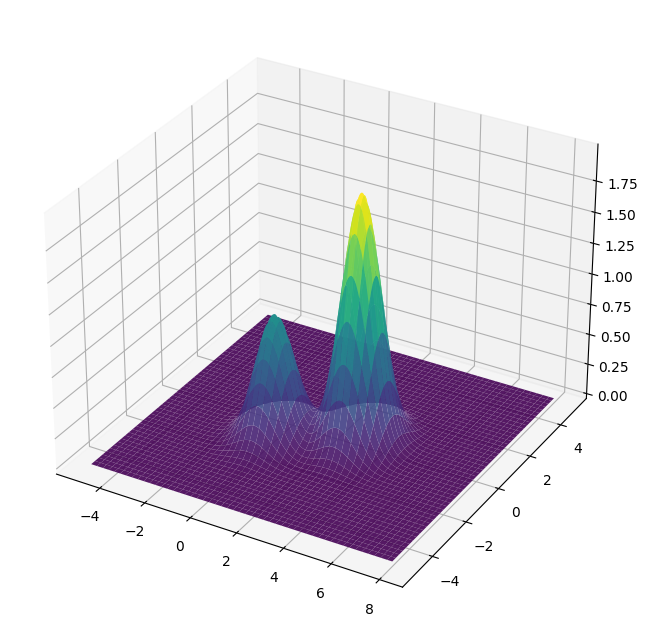

In [70]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D  # Required for 3D plotting

fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(111, projection='3d')

# Plot the surface
surf = ax.plot_surface(X, Y, Z, cmap='viridis', edgecolor='none', alpha=0.9)

In [92]:
import scipy.optimize

scipy.optimize.minimize(lambda x: -f(x[0], x[1]), np.random.rand(2))

      fun: -2.0000454102397254
 hess_inv: array([[ 0.2502136 , -0.00087237],
       [-0.00087237,  0.25669728]])
      jac: array([ 2.08616257e-07, -1.40070915e-06])
  message: 'Optimization terminated successfully.'
     nfev: 72
      nit: 13
     njev: 24
   status: 0
  success: True
        x: array([ 2.99993191e+00, -2.30625583e-05])

In [96]:


def g(t):
    x, y = t
    
    def h(x, y):
        return -(exp(-(x**2 + (y + 1)**2)) + 2 * exp(-((x - 3)**2 + y**2)))
    
    
    return h(x, y).x, grad(h)(x, y)

g([1., 1.])



(-0.0202138409972564, [-0.0404276819945128, 0.053903575992683736])

In [118]:
scipy.optimize.minimize(g, np.random.rand(2), jac=True)

      fun: -2.000045410239852
 hess_inv: array([[ 0.25793424, -0.00789325],
       [-0.00789325,  0.25802371]])
      jac: array([ 7.06155648e-07, -7.14492915e-07])
  message: 'Optimization terminated successfully.'
     nfev: 25
      nit: 11
     njev: 25
   status: 0
  success: True
        x: array([ 2.99993205e+00, -2.28883649e-05])

## Reverse mode autodiff

- In reverse mode autodiff, we reverse the order in which the partial derivatives are accumulated.

![reverse mode ad](https://rufflewind.com/img/reverse-mode-automatic-differentiation-graph.png)

Let's see how this works for the simple function defined above. For an as-yet-to-be-determined variable $s$, we have:

\begin{align}
\frac{\partial s}{\partial z} &= {?}  \\
\frac{\partial s}{\partial b} &= \frac{\partial s}{\partial z} \\
\frac{\partial s}{\partial a} &= \frac{\partial s}{\partial z} \\
\frac{\partial s}{\partial y} &= x \cdot \frac{\partial s}{\partial a} \\
\frac{\partial s}{\partial x} &= y \cdot \frac{\partial s}{\partial a} + \cos(x) \cdot \frac{\partial s}{\partial b}
\end{align}

Translating this into code, we get:
    
    gz = ?
    gb = gz
    ga = gz
    gy = x * ga
    gx = y * ga + cos(x) * gb
    
The variables `gz`$=\partial{s}/\partial{z}$ are referred to as `adjoint` variables.

In [120]:
from dataclasses import field 

@dataclass
class Node:
    x: float
    children: list[(float, 'Node')] = field(default_factory=list)
    _grad: float = None

In [128]:
def _add_T(a: Node, b: Node):
    z = Node(x=a.x + b.x)
    a.children.append((1.0, z))
    b.children.append((1.0, z))
    return z

Node.__add__ = _add_T

x = Node(1.)
y = Node(2.)
z = x + y



Node(x=2.0, children=[(1.0, Node(x=3.0, children=[], _grad=None))], _grad=None)

In [158]:
def grad(self):
    print(f"grad of {self}")
    if self._grad is None:
        self._grad = sum(w * c.grad() for w, c in self.children)
    return self._grad
    

Node.grad = grad


x = Node(1.)
y = Node(2.)
z = x + y



In [139]:
x = Node(1.)
y = Node(2)
z = x + y
z._grad = 1


In [143]:
y.grad()

grad of Node(x=2, children=[(1.0, Node(x=3.0, children=[], _grad=1))], _grad=1.0)


1.0

In [148]:
def _mul_T(a: Node, b: Node):
    z = Node(a.x * b.x)
    a.children.append((b.x, z))
    b.children.append((a.x, z))
    return z

Node.__mul__ = _mul_T

x = Node(1.)
y = Node(2.)

z = x * y

z._grad = 1.0

y.grad()

1.0

In [306]:
a = Node(1)
b = Node(2)
x = a * b
x._grad = 1
b.grad()

1

In [159]:
def sin_T(a: Node):
    z = Node(math.sin(a.x))
    a.children.append((math.cos(a.x), z))
    return z

In [167]:
x = Node(2)
y = Node(1)
z = x * y + sin_T(x)
z._grad = 1

x.grad()

grad of Node(x=2, children=[(1, Node(x=2, children=[(1.0, Node(x=2.909297426825682, children=[], _grad=1))], _grad=None)), (-0.4161468365471424, Node(x=0.9092974268256817, children=[(1.0, Node(x=2.909297426825682, children=[], _grad=1))], _grad=None))], _grad=None)
grad of Node(x=2, children=[(1.0, Node(x=2.909297426825682, children=[], _grad=1))], _grad=None)
grad of Node(x=2.909297426825682, children=[], _grad=1)
grad of Node(x=0.9092974268256817, children=[(1.0, Node(x=2.909297426825682, children=[], _grad=1))], _grad=None)
grad of Node(x=2.909297426825682, children=[], _grad=1)


0.5838531634528576

In [168]:
y.grad()

grad of Node(x=1, children=[(2, Node(x=2, children=[(1.0, Node(x=2.909297426825682, children=[], _grad=1))], _grad=1.0))], _grad=None)
grad of Node(x=2, children=[(1.0, Node(x=2.909297426825682, children=[], _grad=1))], _grad=1.0)


2.0

## Autodiff in Jax

In [50]:
import jax.numpy as jnp

def f(x):
    a = x ** 2
    b = jnp.cos(x)
    return a + b


In [51]:
df = jax.grad(f)

df(1.)

Array(1.158529, dtype=float32, weak_type=True)

In [52]:
jax.make_jaxpr(df)(1.)

{ lambda ; a:f32[]. let
    b:f32[] = integer_pow[y=2] a
    c:f32[] = integer_pow[y=1] a
    d:f32[] = mul 2.0 c
    e:f32[] = cos a
    f:f32[] = sin a
    _:f32[] = add b e
    g:f32[] = neg 1.0
    h:f32[] = mul g f
    i:f32[] = mul 1.0 d
    j:f32[] = add_any h i
  in (j,) }

In [58]:
jax.make_jaxpr(jax.jacfwd(f))(1.)

{ lambda ; a:f32[]. let
    b:i32[1,1] = iota[dimension=0 dtype=int32 shape=(1, 1) sharding=None] 
    c:i32[1,1] = iota[dimension=1 dtype=int32 shape=(1, 1) sharding=None] 
    d:i32[1,1] = add b 0
    e:bool[1,1] = eq d c
    f:f32[1,1] = convert_element_type[new_dtype=float32 weak_type=False] e
    g:f32[1,1] = slice[limit_indices=(1, 1) start_indices=(0, 0) strides=None] f
    h:f32[1] = reshape[dimensions=None new_sizes=(1,)] g
    i:f32[1] = convert_element_type[new_dtype=float32 weak_type=True] h
    j:f32[] = integer_pow[y=2] a
    k:f32[] = integer_pow[y=1] a
    l:f32[] = mul 2.0 k
    m:f32[1] = mul i l
    n:f32[] = cos a
    o:f32[] = sin a
    p:f32[1] = mul i o
    q:f32[1] = neg p
    _:f32[] = add j n
    r:f32[1] = add m q
    s:f32[1] = slice[limit_indices=(1,) start_indices=(0,) strides=None] r
    t:f32[] = reshape[dimensions=None new_sizes=()] s
  in (t,) }

## Custom derivatives

- In some cases it can be advantageous to define custom derivatives for increased speed or numerical stability.

In [63]:
def f(x):
    return jnp.log(1 + jnp.exp(x))

jax.grad(f)(100.)

Array(nan, dtype=float32, weak_type=True)

- To do this in Jax we can use the `custom_jvp` decorator.
- (JVP stands for 'Jacobi vector product').

In [72]:
@jax.custom_jvp
def f(x):
    return jnp.log(1 + jnp.exp(x))

@f.defjvp
def f_jvp(primals, tangents):
    x, = primals
    dx, = tangents
    # df = e^x dx / (1 + e^x) = dx / (1 + e^{-x})
    return f(x), dx / (1 + jnp.exp(-x))
    
jax.value_and_grad(f)(10.)

(Array(10.000046, dtype=float32, weak_type=True),
 Array(0.9999546, dtype=float32, weak_type=True))

## Fixed-point conditions
- Sometimes we have functions whose values are defined by fixed-point conditions. 
- Numerical optimization/EM:

$$\nabla f(x_t)=0 \iff x_t - \alpha \nabla f(x_{t-1}) = x_t$$

- [Deep equilibrium models](https://arxiv.org/abs/1909.01377)

## A simpler example

- Use Newton iteration to compute square roots. 
- i.e., find a root of $x^2 - a$ for fixed $a$.
- Newton's method:
  $$x_{n+1} = x_n - \frac{f(x_n)}{f'(x_n)} = x_n - \frac{x_n^2 - a}{2x_n} = \frac{1}{2}\left(x_n + \frac{a}{x_n} \right)$$
  
- Only requires basic arithmetic operations.
- Known since Babylonian times!!

In [241]:
def babyroot(a):
    x = a
    for _ in range(1000):
        x = .5 * (x + a / x)
    return x

babyroot(2)

1.414213562373095

In [243]:
# jax.make_jaxpr(jax.grad(babyroot))(1.)

Now let's customize the derivative: